In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.integrate import odeint

# Discovering governing equations using the SINDy algorithm

Paper: https://www.pnas.org/content/113/15/3932

SINDy provides an algorithm to discover governing dynamical equations given a time series **x(t)**. The three steps in this algorithm are:
 - Time derivative: Perhaps the trickiest part, especially for noisy time series although one can use total variation regularized derivatives for such cases as in [here](https://github.com/stur86/tvregdiff)
 - Basis: Some non-linear basis of the original time series that could be polynomial, trigonometric (see the paper above)
 - Regularized linear regression: Apply LASSO and/or sequential thresholding least squares.
 
I have personally found that SINDy is not so good with series that are too noisy and/or have trends. Both these problems could be addressed using pre-processing.

SINDy can also be used for **forecasting**, which is trivial once one discovers the dynamical equations.

## Create synthetic dataset

Had trouble finding a good function. 

**REMEMBER**: change `dx1dt`, `dx2dt` also if you change the ranfun below.

In [2]:
def ranfun(y, t):
    x1, x2 = y
    dxdt = [-x1**3 - x2, x1 - x2**3]
    return dxdt

t = np.linspace(0, 10, 1001)

# The following two functions work great, with alpha = 0.0001, they are being correctly classified.
#y0 = [0.1, 0.05] # LINEAR: small x1, x2 => Linear coupled oscillator
y0 = [0.5, 0.5] # NON-LINEAR: Getting close to triggering non-linear effects

**Solve** the ODE:

$$
\begin{align}
\frac{dx_1}{dt} &= -x_1^3 - x_2 \\
\frac{dx_2}{dt} &= x_1 - x_2^3 
\end{align}
$$

In [3]:
sol_new = odeint(ranfun, y0, t)

## Step 1: Compute the time derivative. 

In this case, we specify it ourselves

#### Plot the solutions

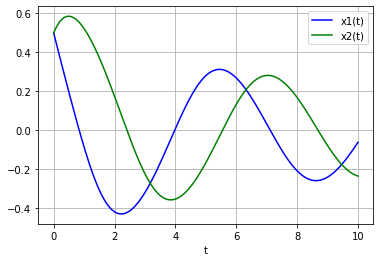

In [4]:
plt.plot(t, sol_new[:, 0], 'b', label='x1(t)')
plt.plot(t, sol_new[:, 1], 'g', label='x2(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()

### Compute the time derivative

Prepare the feature array out of the solution array above

In [5]:
x1 = sol_new[:,0]
x2 = sol_new[:,1]

dx1dt = -sol_new[:,0]**3 - sol_new[:,1]
dx2dt =  sol_new[:,0]    - sol_new[:,1]**3

In [6]:
X = np.zeros((sol_new.shape[0], sol_new.shape[1]))

X[:, 0] = x1 # dx1/dt
X[:, 1] = x2 # dx2/dt

## Step 2: Construct a polynomial (or trig) basis to do the regression

In [7]:
from sklearn.preprocessing import PolynomialFeatures

dum_data = pd.DataFrame(x1, columns=['x1'])
dum_data['x2'] = x2

deg = 3

p = PolynomialFeatures(degree=deg,include_bias=True).fit(dum_data)
xpoly = p.fit_transform(dum_data)
newdf = pd.DataFrame(xpoly, columns = p.get_feature_names(dum_data.columns))

print("Feature names:",list(newdf))#newdf.columns.values.tolist())
print("Feature array shape:",newdf.shape)

Feature names: ['1', 'x1', 'x2', 'x1^2', 'x1 x2', 'x2^2', 'x1^3', 'x1^2 x2', 'x1 x2^2', 'x2^3']
Feature array shape: (1001, 10)


## Step 3: LASSO 

(or Ridge/OLS with sequential thresholding: that is first do the fit with Ridge/OLS. Then discard any features below a certain value. Do the fit again...)

low alpha -> OLS

high alpha -> most features zero

**alpha** is a hyperparameter

In [8]:
from sklearn import linear_model

mod = linear_model.Lasso(alpha=0.0001)
mod

Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

### Prepare training data

In [9]:
newdf_train = newdf[:800]
dx1dt_train = dx1dt[:800]
dx2dt_train = dx2dt[:800]

### dx1/dt

In [10]:
#mod.fit(newdf_train, dxdt_train)
mod.fit(dum_data, dx1dt)
print(mod.coef_)
print(mod.intercept_)

[-0.10661092 -0.99988407]
0.0004712401651750242


In [11]:
mod.fit(newdf_train, dx1dt_train)
print(mod.coef_) # should give the 3rd (x2) + 4th (x1^2) argument non-zero
print(mod.intercept_)

[ 0.         -0.05576026 -0.99852418  0.         -0.         -0.01819165
 -0.50202469 -0.          0.         -0.        ]
0.0033302444886464805


In [12]:
fit_dx1 = pd.DataFrame(columns=newdf.columns)
fit_dx1.loc[0] = mod.coef_
fit_dx1.head()

,1,x1,x2,x1^2,x1 x2,x2^2,x1^3,x1^2 x2,x1 x2^2,x2^3
0,0.0,-0.05576,-0.998524,0.0,-0.0,-0.018192,-0.502025,-0.0,0.0,-0.0


### RESULT: Correctly identifies 

$dx_1/dt \sim -x_2 - x_1^3$

with minor contributions from other terms that could be gotten rid of by applying a threshold

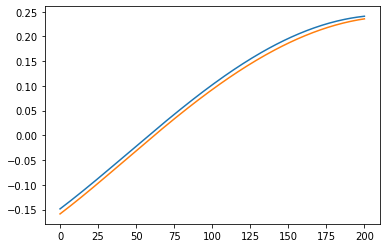

In [13]:
# PLOT results
ypred = mod.predict(newdf[800:])
plt.plot(ypred)
plt.plot(dx1dt[800:])

### dx2/dt

In [14]:
mod.fit(newdf_train, dx2dt_train)
print(mod.coef_) # should give the 2nd (x1) + last (x2^3) argument non-zero
print(mod.intercept_)

[ 0.          0.99491832 -0.02198579 -0.         -0.         -0.04791986
  0.          0.         -0.         -0.82689872]
0.0022126622685510883


In [15]:
fit_dx2 = pd.DataFrame(columns=newdf.columns)
fit_dx2.loc[0] = mod.coef_
fit_dx2.head()

,1,x1,x2,x1^2,x1 x2,x2^2,x1^3,x1^2 x2,x1 x2^2,x2^3
0,0.0,0.994918,-0.021986,-0.0,-0.0,-0.04792,0.0,0.0,-0.0,-0.826899


### RESULT: Correctly identifies 

$dx_2/dt \sim x_1 - x_2^3$

with minor contributions from other terms that could be gotten rid of by applying a threshold

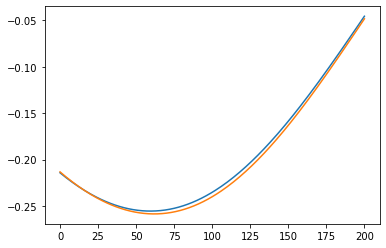

In [16]:
# PLOT results
# Consistent with the above: because the model is picking up x2^2 instead of x2^3, the predictions are off!!
ypred = mod.predict(newdf[800:])
plt.plot(ypred)
plt.plot(dx2dt[800:])